<a href="https://colab.research.google.com/github/shreeyashm/Smart-India-Hackathon-2019/blob/main/sihcode_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pickle
import os
os.sys.path
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 4
default_image_size = tuple((256,256))
image_size = 0
directory_root = '/content/drive/My Drive/SIHDATA'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".png") == True or image_directory.endswith(".PNG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")


[INFO] Loading images ...
[INFO] Processing Healthy ...
[INFO] Processing Stem Rust ...
[INFO] Processing Fusarium Head ...
[INFO] Image loading completed


In [ ]:
image_size = len(image_list)

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

with open('/content/drive/My Drive/SIHModel/label_transform.pkl','wb') as n:
    pickle.dump(label_binarizer,n)
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

np_image_list = np.array(image_list, dtype=np.float16) / 225.0


['Fusarium Head' 'Healthy' 'Stem Rust']


In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))


model.summary()

[INFO] Spliting data to train, test
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
activation_36 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_37 (Activation)   (None, 85, 

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )


13/13 [==============================] - 2s 116ms/step - loss: 0.5222 - acc: 0.7940 - val_loss: 0.5742 - val_acc: 0.7619
Epoch 13/25
13/13 [==============================] - 2s 117ms/step - loss: 0.5296 - acc: 0.8004 - val_loss: 0.7862 - val_acc: 0.7143
Epoch 14/25
13/13 [==============================] - 2s 121ms/step - loss: 0.6260 - acc: 0.7682 - val_loss: 0.8185 - val_acc: 0.8095
Epoch 15/25
13/13 [==============================] - 2s 118ms/step - loss: 0.6561 - acc: 0.7179 - val_loss: 1.0591 - val_acc: 0.7619
Epoch 16/25
13/13 [==============================] - 2s 117ms/step - loss: 0.5092 - acc: 0.7940 - val_loss: 0.5557 - val_acc: 0.6905
Epoch 17/25
13/13 [==============================] - 2s 117ms/step - loss: 0.7717 - acc: 0.7518 - val_loss: 0.8589 - val_acc: 0.8095
Epoch 18/25
13/13 [==============================] - 2s 117ms/step - loss: 0.8175 - acc: 0.6810 - val_loss: 0.8337 - val_acc: 0.8095
Epoch 19/25
13/13 [==============================] - 2s 116ms/step - loss: 0.4501

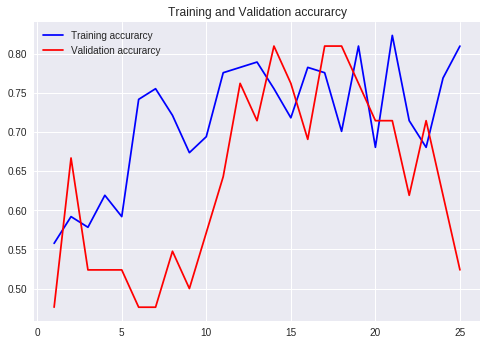

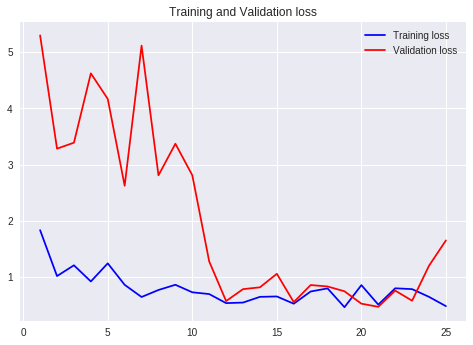

[INFO] Calculating model accuracy
14/14 [==============================] - 0s 4ms/step
Test Accuracy: 52.3809552192688


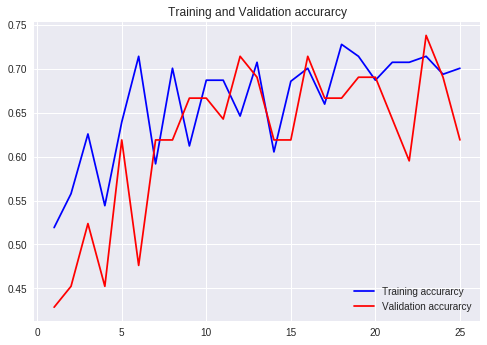

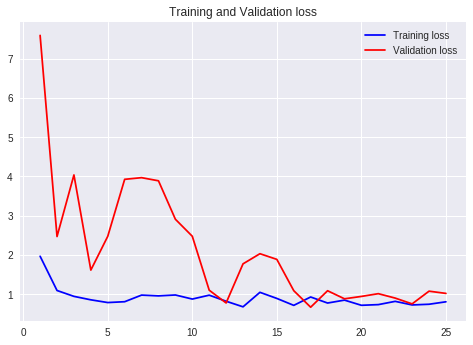

[INFO] Calculating model accuracy
14/14 [==============================] - 0s 4ms/step
Test Accuracy: 61.90476417541504


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

In [ ]:
# save the model to disk
print("[INFO] Saving model...")
with open('/content/drive/My Drive/SIHModel/cnn_model.pkl', 'wb') as f:
    pickle.dump(model,f)

[INFO] Saving model...


FileNotFoundError: ignored